In [ ]:
!git clone https://github.com/gveres/donateacry-corpus

Cloning into 'donateacry-corpus'...
remote: Enumerating objects: 1616, done.
remote: Total 1616 (delta 0), reused 0 (delta 0), pack-reused 1616
Receiving objects: 100% (1616/1616), 67.06 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (1587/1587), done.


In [ ]:
pip install librosa==0.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.1/213.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.7 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.2.post1
    Uninstalling librosa-0.10.2.post1:
      Successfully uninstalled librosa-0.10.2.post1


In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile as wav
import numpy as np
from numpy.lib import stride_tricks
import torch
import torchvision
import cv2
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision import transforms

In [ ]:
def read_audio(conf, pathname, trim_long_data):
  y, sr = librosa.load(pathname, sr=conf.sampling_rate)
  if 0 < len(y):
    y, _ = librosa.effects.trim(y)

  if(len(y))>conf.samples:
    if trim_long_data:
      y = y[0:conf.samples]
  else:
    padding = conf.samples - len(y)
    offset = padding // 2
    y = np.pad(y, (offset, conf.samples - len(y) - offset), "constant")
  return y

In [ ]:
def audio_to_melspectrogram(conf, audio):
  spectrogram = librosa.feature.melspectrogram(y=audio,
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
  spectrogram = librosa.power_to_db(spectrogram)
  spectrogram = spectrogram.astype(np.float32)
  return spectrogram

In [ ]:
def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    return mels

In [ ]:
class conf:
  sampling_rate = 16000
  duration = 7
  hop_length = 100 * duration
  fmin = 20
  fmax = sampling_rate // 2
  n_mels = 128
  n_fft = n_mels * 20
  samples = sampling_rate * duration

In [ ]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [ ]:
def rename_file(img_name):
  img_name = img_name.split('/')[-1]
  img_name = img_name[:-4]
  img_name = img_name + '.jpg'
  return img_name

In [ ]:
import gc
import matplotlib
matplotlib.use('Agg')
def save_image_from_sound(img_path):
    filename = rename_file(img_path)

    x = read_as_melspectrogram(conf, img_path, trim_long_data=False, debug_display=True)
    #x_color = mono_to_color(x)

    # plt.imshow(x, interpolation='nearest')
    # plt.savefig(filename)
    # plt.show()

    # plt.close()
    # del x
    # gc.collect()
    return x

In [ ]:
to_folders = ["hungry", "burping", "discomfort", "belly_pain", "tired"]
X, Y = [], []
for to_folder in to_folders:
  for i, fn in enumerate(os.listdir("/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/"+to_folder)):
    path = '/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/'+ to_folder + "/" + fn
    x = save_image_from_sound(path)[::, :161]
    x = np.stack([x,np.zeros_like(x),np.zeros_like(x)],axis = 2)
    X.append(x)
    Y.append(to_folders.index(to_folder))

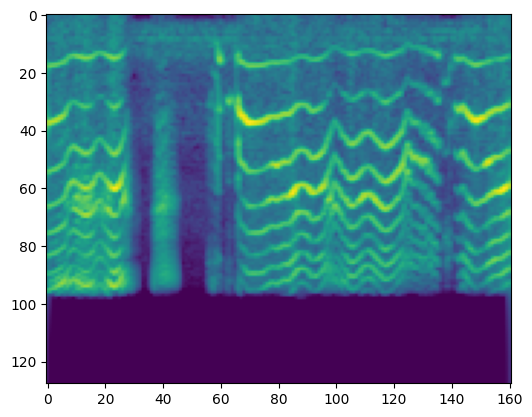

(128, 161, 3)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X[0][:,:,0])
plt.show()
X[0].shape

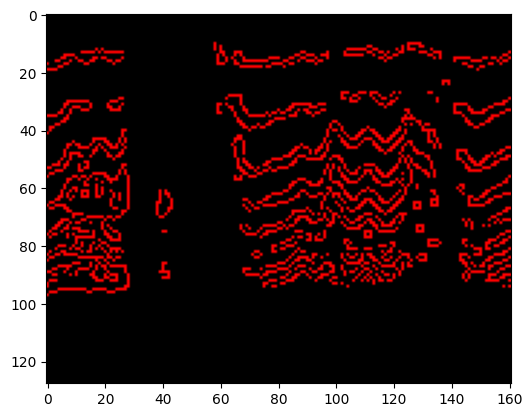

In [ ]:
# prompt: apply edge detection on images

import cv2
X_edge = []
for x in X:
  x = np.uint8(x)
  #slicecanny = cv2.Canny(slice1Copy,1,100)
  x_edge1 = cv2.Canny(x, 100, 200)
  X_edge.append(np.stack([x_edge1,np.zeros_like(x_edge1),np.zeros_like(x_edge1)],axis = 2))
# Display the first image with edge detection applied
plt.imshow(X_edge[0], cmap='gray')
plt.show()


In [ ]:
X_edge[0].shape

(128, 161, 3)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_edge, Y, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
len(X_train),len(X_test)

(365, 92)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
smote = SMOTE()

ros = RandomOverSampler(random_state=42)
X_train_resampled, Y_train =ros.fit_resample(X_train.reshape(-1, 128*161*3), Y_train)

X_train = X_train_resampled.reshape(-1, 128,161,3)

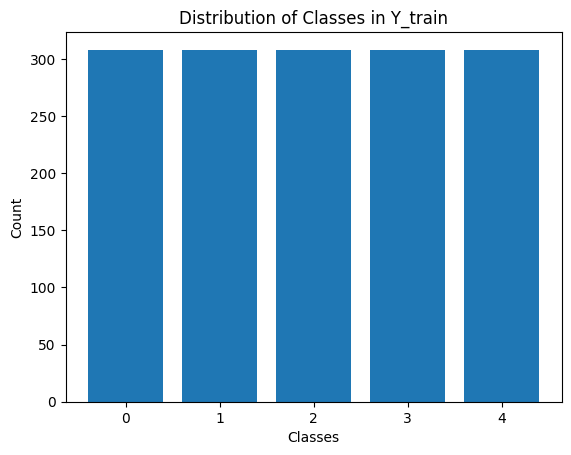

In [ ]:
# prompt: bar plot for Y_train

import matplotlib.pyplot as plt

# Count the occurrences of each class
unique, counts = np.unique(Y_train, return_counts=True)

# Create a bar plot
plt.bar(unique, counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Classes in Y_train')
plt.show()


In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# # datagen = ImageDataGenerator(zoom_range=0.2, width_shift_range=0.2)
# datagen = ImageDataGenerator(zoom_range=0.2)
# datagen.fit(X_train[:len(X_train)//4])

# X_train_augmented = []
# Y_train_augmented = []

# for x, y in datagen.flow(X_train[:len(X_train)//4], Y_train[:len(X_train)//4], batch_size=32):
#   X_train_augmented.append(x)
#   Y_train_augmented.append(y)

# X_train_augmented = np.concatenate(X_train_augmented)
# Y_train_augmented = np.concatenate(Y_train_augmented)



In [ ]:
# prompt: use pretrained resnet50 to train on the data

from tensorflow.keras.applications import ResNet50,ResNet152, ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 161, 3))

# Freeze the convolutional layers in the base model
base_model.trainable = False

# Build the new model
model = Sequential()
model.add(base_model)
model.add(Flatten())
#model.add(Dropout(0.5))
# model.add(Dense(1024, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=3, validation_data=(X_test, Y_test))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6016 - loss: 5.4049 - val_accuracy: 0.7826 - val_loss: 5.9570
Epoch 2/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.9899 - loss: 0.0381 - val_accuracy: 0.7717 - val_loss: 5.6462
Epoch 3/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 1.0000 - loss: 7.7464e-04 - val_accuracy: 0.7609 - val_loss: 5.3063


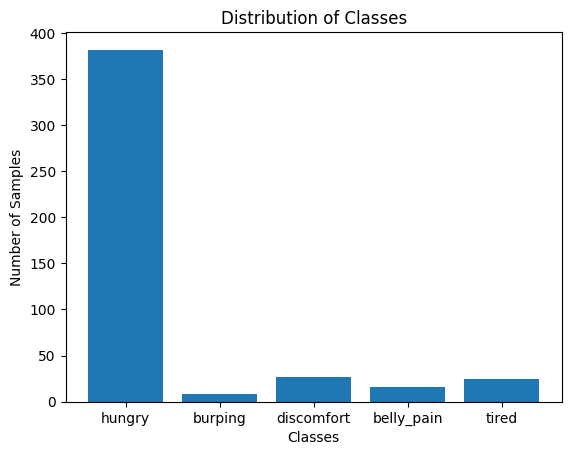

In [ ]:
# prompt: plot a histogram about the classes using to_folders to replace class numbers

import matplotlib.pyplot as plt

# Count the occurrences of each class
class_counts = [Y.count(i) for i in range(len(to_folders))]

# Create a bar plot
plt.bar(to_folders, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes')
plt.show()


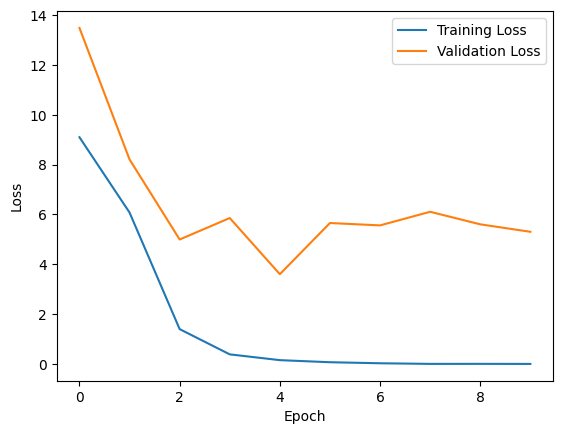

In [ ]:
# prompt: plot the loss curves

# Plot the loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


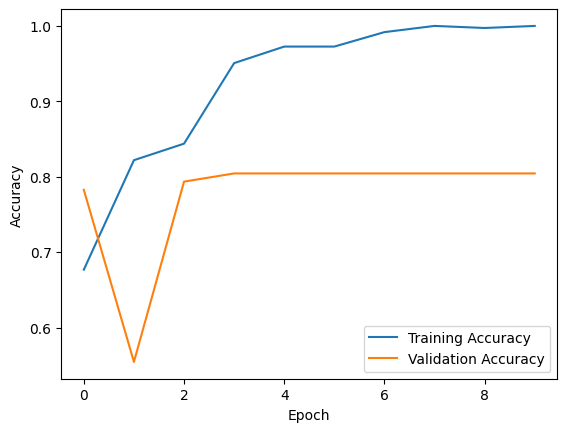

In [ ]:
# prompt: plot the accuracy curves

# Plot the accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 11s/step


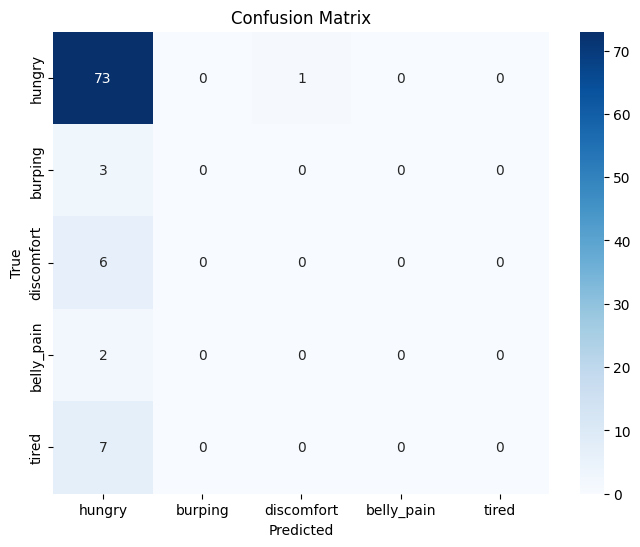

In [ ]:
# prompt: plot the confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict classes for the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=to_folders, yticklabels=to_folders)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
